In [1]:
# %%
import os
import gc
import torch
os.chdir("/work/pi_jensen_umass_edu/jnainani_umass_edu/CircuitAnalysisSAEs")
import json
from sae_lens import SAE, HookedSAETransformer
from circ4latents import data_gen
from functools import partial
import einops

# Function to manage CUDA memory and clean up
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()
# cleanup_cuda()
# Load the config
with open("config.json", 'r') as file:
   config = json.load(file)
token = config.get('huggingface_token', None)
os.environ["HF_TOKEN"] = token

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

hf_cache = "/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/huggingface_cache/hub"
os.environ["HF_HOME"] = hf_cache

# Load the model
model = HookedSAETransformer.from_pretrained("google/gemma-2-9b", device=device, cache_dir=hf_cache)

Device: cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [2]:
layers= [7, 14, 21, 40]
l0s = [92, 67, 129, 125]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res", sae_id=f"layer_{layers[i]}/width_16k/average_l0_{l0s[i]}", device=device)[0] for i in range(len(layers))]

# Data Gen

In [3]:
# %%
# Updated version to return JSON with more names and structure for correct and incorrect keying examples

import json
import random

# Expanding the name pool with a larger set of names
extended_name_pool = [
    "Bob", "Sam", "Lilly", "Rob", "Alice", "Charlie", "Sally", "Tom", "Jake", "Emily", 
    "Megan", "Chris", "Sophia", "James", "Oliver", "Isabella", "Mia", "Jackson", 
    "Emma", "Ava", "Lucas", "Benjamin", "Ethan", "Grace", "Olivia", "Liam", "Noah"
]

for name in extended_name_pool:
    assert len(model.tokenizer.encode(name)) == 2, f"Name {name} has more than 1 token"

# Function to generate the dataset with correct and incorrect keying into dictionaries
def generate_extended_dataset(name_pool, num_samples=5):
    dataset = []
    
    for _ in range(num_samples):
        # Randomly select 5 names from the pool
        selected_names = random.sample(name_pool, 5)
        # Assign random ages to the selected names
        age_dict = {name: random.randint(10, 19) for name in selected_names}
        
        # Create a correct example
        correct_name = random.choice(list(age_dict.keys()))
        correct_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> print(age["{correct_name}"])\n'
        correct_response = age_dict[correct_name]
        correct_token = str(correct_response)[0]
        
        # Create an incorrect example with a name not in the dictionary
        incorrect_name = random.choice([name for name in name_pool if name not in age_dict])
        incorrect_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> print(age["{incorrect_name}"])\n'
        incorrect_response = "Traceback"
        incorrect_token = "Traceback"
        
        # Append the pair of correct and incorrect examples
        dataset.append({
            "correct": {
                "prompt": correct_prompt,
                "response": correct_response,
                "token": correct_token
            },
            "error": {
                "prompt": incorrect_prompt,
                "response": incorrect_response,
                "token": incorrect_token
            }
        })
        
    return dataset

# Generate the extended dataset
json_dataset = generate_extended_dataset(extended_name_pool, num_samples=10000)

# Output the JSON structure

# %%
clean_prompts = []
corr_prompts = []

answer_token = model.to_single_token("1")
traceback_token = model.to_single_token("Traceback")

for item in json_dataset[:50]:
    corr_prompts.append(item["correct"]["prompt"])
    clean_prompts.append(item["error"]["prompt"])

clean_tokens = model.to_tokens(clean_prompts)
corr_tokens = model.to_tokens(corr_prompts)

# %%
def logit_diff_fn(logits):
    err = logits[:, -1, traceback_token]
    no_err = logits[:, -1, answer_token]
    return (err - no_err).mean()

# Disable gradients for all parameters
for param in model.parameters():
   param.requires_grad_(False)

# # Compute logits for clean and corrupted samples
logits = model(clean_tokens)
clean_diff = logit_diff_fn(logits)

logits = model(corr_tokens)
corr_diff = logit_diff_fn(logits)

print(f"clean_diff: {clean_diff}")
print(f"corr_diff: {corr_diff}")

# # Cleanup
del logits
cleanup_cuda()

# # Define error type metric
def _err_type_metric(logits, clean_logit_diff, corr_logit_diff):
    patched_logit_diff = logit_diff_fn(logits)
    return (patched_logit_diff - corr_logit_diff) / (clean_logit_diff - corr_logit_diff)

err_metric_denoising = partial(_err_type_metric, clean_logit_diff=clean_diff, corr_logit_diff=corr_diff)

clean_diff: 6.536237716674805
corr_diff: -6.750219345092773


In [4]:
simple_dataset = []
simple_labels = []
answer_token = model.to_single_token("1")
traceback_token = model.to_single_token("Traceback")
for item in json_dataset:
    simple_dataset.append(item["correct"]["prompt"])
    simple_dataset.append(item["error"]["prompt"])
    simple_labels.append(answer_token)
    simple_labels.append(traceback_token)
simple_dataset = model.to_tokens(simple_dataset)
simple_labels = torch.tensor(simple_labels)
permutation = torch.randperm(len(simple_dataset))
simple_dataset = simple_dataset[permutation]
simple_labels = simple_labels[permutation]

In [4]:
# simple_dataset = []
# simple_labels = []
clean_dataset = []
corr_dataset = []
clean_labels = []
corr_labels = []

answer_token = model.to_single_token("1")
traceback_token = model.to_single_token("Traceback")

for item in json_dataset:
    clean_dataset.append(item["error"]["prompt"])
    corr_dataset.append(item["correct"]["prompt"])
    clean_labels.append(traceback_token)
    corr_labels.append(answer_token)


clean_tok_dataset = model.to_tokens(clean_dataset)
clean_labels = torch.tensor(clean_labels)

corr_tok_dataset = model.to_tokens(corr_dataset)
corr_labels = torch.tensor(corr_labels)


In [35]:
permutation = torch.randperm(len(clean_tok_dataset))
clean_tok_dataset = clean_tok_dataset[permutation]
clean_labels = clean_labels[permutation]

corr_tok_dataset = corr_tok_dataset[permutation]
corr_labels = corr_labels[permutation]

# Sparse Mask Definition

In [5]:
import signal
import torch.nn as nn
class KeyboardInterruptBlocker:
    def __enter__(self):
        # Ignore SIGINT (KeyboardInterrupt) and save the old handler
        self.original_handler = signal.signal(signal.SIGINT, signal.SIG_IGN)

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore the original SIGINT handler
        signal.signal(signal.SIGINT, self.original_handler)

class SparseMask(nn.Module):
    def __init__(self, shape, l1, seq_len=None):
        super().__init__()
        if seq_len is not None:
            self.mask = nn.Parameter(torch.ones(seq_len, shape))
        else:
            self.mask = nn.Parameter(torch.ones(shape))
        self.l1 = l1
        self.max_temp = torch.tensor(1000.0)
        self.sparsity_loss = None
        self.ratio_trained = 1
        self.temperature = 1


    def forward(self, x, binary=False, mean_ablation=None):
        if binary and mean_ablation is not None:
            binarized = (self.mask > 0).float().to(x.device)
            return x * binarized + mean_ablation * (~binarized.bool())
        if binary:
            # binary mask, 0 if negative, 1 if positive
            binarized = (self.mask > 0).float()
            return x * binarized
        
        self.temperature = self.max_temp ** self.ratio_trained
        mask = torch.sigmoid(self.mask * self.temperature)
        self.sparsity_loss = torch.abs(mask).sum() * self.l1

        if mean_ablation is None:
            return x * mask
        else:
            return x * mask + mean_ablation * (~mask.bool())

for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=67)


In [6]:

def apply_mask(mask_idxs, sae):
    mask = torch.full_like(sae.mask.mask, -10)
    mask[mask_idxs] = 10
    sae.mask.mask.data = mask

def load_sparsemask(mask_path):
    json_mask = json.load(open(mask_path))
    for sae in saes:
        apply_mask(json_mask[sae.cfg.hook_name], sae)

bos_token_id = model.tokenizer.bos_token_id
pad_token_id = model.tokenizer.pad_token_id
def build_sae_hook_fn(sae, sequence, cache_grads=False, circuit_mask=None, use_mask=False, binarize_mask=False, cache_masked_activations=False, cache_sae_activations=False, mean_ablate=False, mean_mask=False):
    # make the mask for the sequence
    mask = torch.ones_like(sequence, dtype=torch.bool)
    mask[sequence == pad_token_id] = False
    mask[sequence == bos_token_id] = False # where mask is false, keep original
    def sae_hook(value, hook):
        # print(f"sae {sae.cfg.hook_name} running at layer {hook.layer()}")
        feature_acts = sae.encode(value)
        if cache_grads:
            sae.feature_acts = feature_acts
            sae.feature_acts.retain_grad()
        
        if cache_sae_activations:
            sae.feature_acts = feature_acts.detach().clone()
        
        if use_mask:
            if mean_mask:
                feature_acts = sae.mask(feature_acts, binary=binarize_mask, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = sae.mask(feature_acts, binary=binarize_mask)

        if circuit_mask is not None:
            mask_method = circuit_mask['mask_method']
            mask_indices = circuit_mask[sae.cfg.hook_name]
            if mask_method == 'keep_only':
                # any activations not in the mask are set to 0
                expanded_circuit_mask = torch.zeros_like(feature_acts)
                expanded_circuit_mask[:, :, mask_indices] = 1
                feature_acts = feature_acts * expanded_circuit_mask
            elif mask_method == 'zero_only':
                feature_acts[:, :, mask_indices] = 0
            else:
                raise ValueError(f"mask_method {mask_method} not recognized")
            
        if cache_masked_activations:
            sae.feature_acts = feature_acts.detach().clone()
        if mean_ablate:
            feature_acts = sae.mean_ablation

        out = sae.decode(feature_acts)
        # choose out or value based on the mask
        mask_expanded = mask.unsqueeze(-1).expand_as(value)
        value = torch.where(mask_expanded, out, value)
        return value
    return sae_hook

def build_hooks_list(sequence,
                    cache_sae_activations=False,
                    cache_sae_grads=False,
                    circuit_mask=None,
                    use_mask=False,
                    binarize_mask=False,
                    mean_mask=False,
                    cache_masked_activations=False,
                    mean_ablate=False,
                    ):
    hooks = []
    # # fake hook that adds zero so gradients propagate through the model
    param = nn.Parameter(torch.tensor(0.0, requires_grad=True))
    hooks.append(
        (
            "blocks.0.hook_resid_pre",
            lambda value, hook: value + param,
        )
    )
    for sae in saes:
        hooks.append(
            (
            sae.cfg.hook_name,
            build_sae_hook_fn(sae, sequence, cache_grads=cache_sae_grads, circuit_mask=circuit_mask, use_mask=use_mask, binarize_mask=binarize_mask, cache_masked_activations=cache_masked_activations, cache_sae_activations=cache_sae_activations, mean_ablate=mean_ablate, mean_mask=mean_mask),
            )
        )
    return hooks 

import gc
def cleanup_cuda():
    torch.cuda.empty_cache()
    gc.collect()


In [7]:
with torch.no_grad():
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens,
            return_type="logits",
            fwd_hooks=build_hooks_list(tokens, cache_sae_activations=True)
            )
    # logits = logitfn(corr_tokens)
    # for sae in saes:
    #     print(sae.feature_acts.shape)
    # del logits
    # cleanup_cuda()

# Token Level Running Mean

In [58]:
from tqdm import tqdm
def running_mean_tensor(old_mean, new_value, n):
    """Update the running mean tensor using the current batch."""
    return old_mean + (new_value - old_mean) / n
def get_sae_means(saes, dataset, total_steps, batch_size=16):
    """
    Compute token-level means across the dataset in a batched manner.
    Args:
        dataset (Tensor): The input dataset of tokenized data.
        total_steps (int): Number of steps to process.
        batch_size (int): Number of examples per batch.
    """
    for sae in saes:
        # Initialize mean_ablation with correct shape
        sae.mean_ablation = torch.zeros((dataset[0].shape[0], sae.cfg.d_sae)).float().to(device)
    total_samples = len(dataset)
    num_batches = (total_samples + batch_size - 1) // batch_size  # Calculate number of batches
    with tqdm(total=min(total_steps, num_batches), desc="Mean Accum Progress") as pbar:
        sample_count = 0  # To track total number of samples processed
        for i in range(0, total_samples, batch_size):
            # Batch selection
            batch_x = dataset[i:i+batch_size]
            with torch.no_grad():
                _ = logitfn(batch_x)  # Get logits (forward pass)
                for sae in saes:
                    # Compute batch mean over tokens
                    batch_mean = sae.feature_acts.mean(dim=0)  # Mean across the batch
                    sample_count += 1 # len(batch_x)  # Update sample count
                    # Update running mean tensor
                    sae.mean_ablation = running_mean_tensor(
                        sae.mean_ablation,
                        batch_mean,
                        sample_count
                    )
            pbar.update(1)  # Update progress bar
            # Stop if we've processed enough steps
            if i // batch_size >= total_steps:
                break
            del batch_mean
            cleanup_cuda()
# get_sae_means(saes, corr_tok_dataset, 5, batch_size=16)

# Completeness

In [9]:
mean_circuit = {"blocks.7.hook_resid_post": [10768, 11635], "blocks.14.hook_resid_post": [2576, 4811, 4834, 6868, 8746, 9066, 12929, 15603], "blocks.21.hook_resid_post": [52, 534, 712, 1197, 1408, 3076, 5066, 7015, 7762, 8082, 8615, 9551, 9663, 10003, 10824, 11416, 11455, 12314, 12598, 14515], "blocks.40.hook_resid_post": [215, 266, 637, 1073, 1322, 1435, 2295, 2493, 2534, 2664, 2881, 2964, 2996, 3960, 4501, 4603, 4689, 4769, 5862, 7622, 7792, 8416, 8778, 9230, 9309, 9682, 10155, 10628, 10936, 11066, 11103, 11579, 11706, 11754, 11839, 12258, 12988, 13095, 13113, 13479, 14423, 15628, 15851], "total_density": 73.0, "avg_density": 18.25, "ce_loss": 0.5223647356033325}

In [10]:
for ind, layer in enumerate(layers):
    print(mean_circuit[f"blocks.{layer}.hook_resid_post"])
    og_mask = torch.ones_like(saes[ind].mask.mask.data).float().to(device)
    print(og_mask.shape)

[10768, 11635]
torch.Size([67, 16384])
[2576, 4811, 4834, 6868, 8746, 9066, 12929, 15603]
torch.Size([67, 16384])
[52, 534, 712, 1197, 1408, 3076, 5066, 7015, 7762, 8082, 8615, 9551, 9663, 10003, 10824, 11416, 11455, 12314, 12598, 14515]
torch.Size([67, 16384])
[215, 266, 637, 1073, 1322, 1435, 2295, 2493, 2534, 2664, 2881, 2964, 2996, 3960, 4501, 4603, 4689, 4769, 5862, 7622, 7792, 8416, 8778, 9230, 9309, 9682, 10155, 10628, 10936, 11066, 11103, 11579, 11706, 11754, 11839, 12258, 12988, 13095, 13113, 13479, 14423, 15628, 15851]
torch.Size([67, 16384])


In [11]:
import torch

# Number of elements to remove from the last dimension
num_remove = 5

# Number of batches to process
num_batches = 3  # Adjust this as needed
batch_size = 16  # Batch size for processing

# Remove random subsets of the mask along the [-1] dimension
def get_indices_to_remove(mask, num_remove):
    active_indices = (mask > 0).nonzero(as_tuple=True)[-1]  # Get indices of active elements in the last dimension
    if len(active_indices) < num_remove:
        raise ValueError("Not enough active elements to remove.")
    indices_to_remove = active_indices[torch.randperm(len(active_indices))[:num_remove]].to(mask.device)  # Move to the same device
    return indices_to_remove

def apply_subset_removal(mask, indices_to_remove):
    indices_to_remove = indices_to_remove.to(mask.device)  # Ensure indices are on the same device
    modified_mask = mask.clone()
    modified_mask.index_fill_(-1, indices_to_remove, 0)  # Set selected elements to 0
    return modified_mask

In [48]:
def adaptive_logit_diff(logits, labels):
    val1, val2 = 175843, 235274
    inv_labels = torch.where(labels == val1, val2, val1)
    correct_logits = logits[torch.arange(logits.shape[0]), -1, labels]
    incorrect_logits = logits[torch.arange(logits.shape[0]), -1, inv_labels]
    return (correct_logits - incorrect_logits).mean()

batch_data = simple_dataset[:16]
batch_labels = simple_labels[:16]
with torch.no_grad():
    logits = model(batch_data)
    full_model_logit_diff = adaptive_logit_diff(logits, batch_labels)
    del logits
    cleanup_cuda()
full_model_logit_diff

tensor(6.7203, device='cuda:0')

In [34]:
get_sae_means(saes, simple_dataset, 5, batch_size=16)

Mean Accum Progress: 6it [00:08,  1.36s/it]                       


In [35]:
for ind, layer in enumerate(layers):
    og_mask = torch.ones_like(saes[ind].mask.mask.data).float().to(device)
    complement_set = torch.tensor(list(set(range(saes[ind].cfg.d_sae)) - set(mean_circuit[f"blocks.{layer}.hook_resid_post"])))
    saes[ind].mask.mask.data = apply_subset_removal(og_mask, complement_set).to(device)
logits = model.run_with_hooks(
                batch_data,
                return_type="logits",
                fwd_hooks=build_hooks_list(
                    batch_data, 
                    cache_sae_activations=False, 
                    use_mask=True, 
                    binarize_mask=True, 
                    mean_mask=True
                )
            )
print(adaptive_logit_diff(logits, batch_labels))


tensor(2.3029, device='cuda:0', grad_fn=<MeanBackward0>)


In [22]:
for ind, layer in enumerate(layers):
    og_mask = torch.ones_like(saes[ind].mask.mask.data).float().to(device)
    complement_set = torch.tensor(list(set(range(saes[ind].cfg.d_sae)) - set(mean_circuit[f"blocks.{layer}.hook_resid_post"])))
    saes[ind].mask.mask.data = apply_subset_removal(og_mask, complement_set).to(device)

batch_data = simple_dataset[:16]
logits = model.run_with_hooks(
                batch_data,
                return_type="logits",
                fwd_hooks=build_hooks_list(
                    batch_data, 
                    cache_sae_activations=False, 
                    use_mask=True, 
                    binarize_mask=True, 
                    mean_mask=True
                )
            )


[10768, 11635]
[2576, 4811, 4834, 6868, 8746, 9066, 12929, 15603]
[52, 534, 712, 1197, 1408, 3076, 5066, 7015, 7762, 8082, 8615, 9551, 9663, 10003, 10824, 11416, 11455, 12314, 12598, 14515]
[215, 266, 637, 1073, 1322, 1435, 2295, 2493, 2534, 2664, 2881, 2964, 2996, 3960, 4501, 4603, 4689, 4769, 5862, 7622, 7792, 8416, 8778, 9230, 9309, 9682, 10155, 10628, 10936, 11066, 11103, 11579, 11706, 11754, 11839, 12258, 12988, 13095, 13113, 13479, 14423, 15628, 15851]


In [12]:
get_indices_to_remove(saes[0].mask.mask.data, 5)

tensor([ 4016, 10878,  7167,  6278,  7607])

In [21]:
complement_set = list(set(range(saes[0].cfg.d_sae)) - set(mean_circuit[f"blocks.{layer}.hook_resid_post"]))
for i in range(300):
    if complement_set[i] != i:
        print(i)
        break

215


In [65]:
# Number of batches to process
num_batches = 15  # Adjust this as needed
batch_size = 16  # Batch size for processing

# # Circuit (random temporary mask)
for sae in saes:
    sae.original_mask = SparseMask(sae.cfg.d_sae, l1=1.0, seq_len=67)
    with torch.no_grad():
        sae.original_mask.mask.data = torch.randint(0, 2, sae.original_mask.mask.shape).float().to(device)

# Generate means for the corrupted distribution
get_sae_means(saes, simple_dataset, num_batches, batch_size=batch_size)

Mean Accum Progress: 16it [00:22,  1.42s/it]                        


In [66]:
# Helper function for batched processing
def calculate_logit_diff(data, labels, n_batches, batch_size, use_sae):
    total_logit_diff = 0.0
    for batch_idx in range(n_batches):
        # Get the batch data
        batch_data = data[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        # print(batch_data.shape)
        batch_labels = labels[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        with torch.no_grad():
            
            if use_sae:
                logits = model.run_with_hooks(
                    batch_data,
                    return_type="logits",
                    fwd_hooks=build_hooks_list(
                        batch_data, 
                        cache_sae_activations=False, 
                        use_mask=True, 
                        binarize_mask=True, 
                        mean_mask=True
                    )
                )
            else: 
                logits = model(batch_data)
            logit_diff = adaptive_logit_diff(logits, batch_labels).item()
            total_logit_diff += logit_diff
            del logits
            cleanup_cuda()
    # Return the average logit difference across batches
    return total_logit_diff / n_batches

# Calculate logit diff for clean and corrupted masks
batch_clean_data = simple_dataset[:batch_size * num_batches]
batch_clean_labels = simple_labels[:batch_size * num_batches]
cleanup_cuda()

In [67]:
# Full model logit diff 
full_model_logit_diff = calculate_logit_diff(batch_clean_data, batch_clean_labels, num_batches, batch_size, use_sae=False)
print(f"Full model logit diff: {full_model_logit_diff}")

# Model logit diff (All ones mask)
for sae in saes:
    with torch.no_grad():
        sae.mask.mask.data = torch.ones_like(sae.mask.mask.data).float().to(device)
model_logit_diff = calculate_logit_diff(batch_clean_data, batch_clean_labels, num_batches, batch_size, use_sae=True)
print(f"Model logit diff: {model_logit_diff}")

# # Circuit logit diff (Original mask)
for ind, layer in enumerate(layers):
    og_mask = torch.ones_like(saes[ind].mask.mask.data).float().to(device)
    complement_set = torch.tensor(list(set(range(saes[ind].cfg.d_sae)) - set(mean_circuit[f"blocks.{layer}.hook_resid_post"])))
    saes[ind].mask.mask.data = apply_subset_removal(og_mask, complement_set).to(device)
    saes[ind].original_mask.mask.data = saes[ind].mask.mask.data.clone()

circuit_logit_diff = calculate_logit_diff(batch_clean_data, batch_clean_labels, num_batches, batch_size, use_sae=True)
print(f"Circuit logit diff: {circuit_logit_diff}")

Full model logit diff: 6.6416096687316895
Model logit diff: 5.071461900075277
Circuit logit diff: 1.2142028570175172


In [68]:
circuit_logit_diff/full_model_logit_diff

0.18281755742646444

In [69]:
circuit_logit_diff/model_logit_diff

0.2394187082425867

In [73]:
random_k_results = []
for i in range(5):
    num_remove = [0, 2, 5, 10]
    indices_rem_list = []
    for ind, sae in enumerate(saes):
        # Get indices to remove based on the original mask
        indices_rem_list.append(get_indices_to_remove(sae.original_mask.mask.data, num_remove[ind]))
    random_k_results.append({"knockout_indices": indices_rem_list})
print(random_k_results)

[{'knockout_indices': [tensor([], device='cuda:0', dtype=torch.int64), tensor([4811, 9066], device='cuda:0'), tensor([10003,  1197,   534,  9663,  5066], device='cuda:0'), tensor([ 4501, 10155, 12988,   637, 11066,  1322, 15628, 11103,  1322, 10936],
       device='cuda:0')]}, {'knockout_indices': [tensor([], device='cuda:0', dtype=torch.int64), tensor([8746, 8746], device='cuda:0'), tensor([11455, 11416, 12314,  7015, 11416], device='cuda:0'), tensor([ 8778,  1322, 11066,  2881, 12988, 11754,  4501,  7792,  2964,  8416],
       device='cuda:0')]}, {'knockout_indices': [tensor([], device='cuda:0', dtype=torch.int64), tensor([8746, 4834], device='cuda:0'), tensor([10003, 11455,  3076, 12598,    52], device='cuda:0'), tensor([11706,  1435,  2295, 10936, 13113,  3960,  4501, 12988,  4769,  2534],
       device='cuda:0')]}, {'knockout_indices': [tensor([], device='cuda:0', dtype=torch.int64), tensor([4834, 6868], device='cuda:0'), tensor([  712,  3076, 11455,    52,    52], device='cuda:0'

In [74]:
for rand_ind, k_results in enumerate(random_k_results):
    print(k_results['knockout_indices'])

[tensor([], device='cuda:0', dtype=torch.int64), tensor([4811, 9066], device='cuda:0'), tensor([10003,  1197,   534,  9663,  5066], device='cuda:0'), tensor([ 4501, 10155, 12988,   637, 11066,  1322, 15628, 11103,  1322, 10936],
       device='cuda:0')]
[tensor([], device='cuda:0', dtype=torch.int64), tensor([8746, 8746], device='cuda:0'), tensor([11455, 11416, 12314,  7015, 11416], device='cuda:0'), tensor([ 8778,  1322, 11066,  2881, 12988, 11754,  4501,  7792,  2964,  8416],
       device='cuda:0')]
[tensor([], device='cuda:0', dtype=torch.int64), tensor([8746, 4834], device='cuda:0'), tensor([10003, 11455,  3076, 12598,    52], device='cuda:0'), tensor([11706,  1435,  2295, 10936, 13113,  3960,  4501, 12988,  4769,  2534],
       device='cuda:0')]
[tensor([], device='cuda:0', dtype=torch.int64), tensor([4834, 6868], device='cuda:0'), tensor([  712,  3076, 11455,    52,    52], device='cuda:0'), tensor([ 1322,  2664,  2664,  2664, 10936,  4603,  2664,  2881, 14423,  1435],
       de

In [75]:
# Evaluate F(C \ K) and F(M \ K) for N batches
for rand_ind, k_results in enumerate(random_k_results):
    for case in ['circuit', 'model']:
        total_knock_logit_diff = 0.0
        for batch_idx in range(num_batches):
            batch_data = batch_clean_data[batch_idx * batch_size : (batch_idx + 1) * batch_size]
            batch_labels = batch_clean_labels[batch_idx * batch_size : (batch_idx + 1) * batch_size]
            with torch.no_grad():
                for ind, sae in enumerate(saes):
                    if case == 'circuit':
                        sae.mask.mask.data = apply_subset_removal(sae.original_mask.mask.data, k_results['knockout_indices'][ind]).to(device)
                    else:
                        all_ones_mask = torch.ones_like(sae.mask.mask.data).float().to(device)
                        sae.mask.mask.data = apply_subset_removal(all_ones_mask, k_results['knockout_indices'][ind]).to(device)
                logits = model.run_with_hooks(
                    batch_data,
                    return_type="logits",
                    fwd_hooks=build_hooks_list(
                        batch_data, 
                        cache_sae_activations=False, 
                        use_mask=True, 
                        binarize_mask=True, 
                        mean_mask=True
                    )
                )
                logit_diff = adaptive_logit_diff(logits, batch_labels).item()
                total_knock_logit_diff += logit_diff
                del logits
                cleanup_cuda()
        # Average logit difference for the case
        avg_knock_logit_diff = total_knock_logit_diff / num_batches
        if case == 'circuit':
            print(f"Random set {rand_ind}, F(C \ K): {avg_knock_logit_diff}")
            random_k_results[rand_ind]['F_C_K'] = avg_knock_logit_diff
        else:
            print(f"Random set {rand_ind}, F(M \ K): {avg_knock_logit_diff}")
            random_k_results[rand_ind]['F_M_K'] = avg_knock_logit_diff


Random set 0, F(C \ K): 0.6087632099787395
Random set 0, F(M \ K): 3.9026493231455484
Random set 1, F(C \ K): 1.5345548391342163
Random set 1, F(M \ K): 4.646350781122844
Random set 2, F(C \ K): 0.9684387048085531
Random set 2, F(M \ K): 4.78669220606486
Random set 3, F(C \ K): 0.9224901835123698
Random set 3, F(M \ K): 4.037944634755452
Random set 4, F(C \ K): 0.814025338490804
Random set 4, F(M \ K): 4.914939181009928


In [93]:
saes[0].original_mask.mask.data[:, 10768]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

In [94]:
# full circuit removal

indices_rem_list_full = []
for ind, sae in enumerate(saes):
    # Get indices to remove based on the original mask
    indices_rem_list_full.append(torch.tensor(mean_circuit[f"blocks.{layers[ind]}.hook_resid_post"]))
indices_rem_list_full

[tensor([10768, 11635]),
 tensor([ 2576,  4811,  4834,  6868,  8746,  9066, 12929, 15603]),
 tensor([   52,   534,   712,  1197,  1408,  3076,  5066,  7015,  7762,  8082,
          8615,  9551,  9663, 10003, 10824, 11416, 11455, 12314, 12598, 14515]),
 tensor([  215,   266,   637,  1073,  1322,  1435,  2295,  2493,  2534,  2664,
          2881,  2964,  2996,  3960,  4501,  4603,  4689,  4769,  5862,  7622,
          7792,  8416,  8778,  9230,  9309,  9682, 10155, 10628, 10936, 11066,
         11103, 11579, 11706, 11754, 11839, 12258, 12988, 13095, 13113, 13479,
         14423, 15628, 15851])]

In [95]:
for case in ['circuit', 'model']:
    total_knock_logit_diff = 0.0
    for batch_idx in range(num_batches):
        batch_data = batch_clean_data[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        batch_labels = batch_clean_labels[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        with torch.no_grad():
            for ind, sae in enumerate(saes):
                if case == 'circuit':
                    sae.mask.mask.data = apply_subset_removal(sae.original_mask.mask.data, indices_rem_list_full[ind]).to(device)
                else:
                    all_ones_mask = torch.ones_like(sae.mask.mask.data).float().to(device)
                    sae.mask.mask.data = apply_subset_removal(all_ones_mask, indices_rem_list_full[ind]).to(device)
            logits = model.run_with_hooks(
                batch_data,
                return_type="logits",
                fwd_hooks=build_hooks_list(
                    batch_data, 
                    cache_sae_activations=False, 
                    use_mask=True, 
                    binarize_mask=True, 
                    mean_mask=True
                )
            )
            logit_diff = adaptive_logit_diff(logits, batch_labels).item()
            total_knock_logit_diff += logit_diff
            del logits
            cleanup_cuda()
    # Average logit difference for the case
    avg_knock_logit_diff = total_knock_logit_diff / num_batches
    if case == 'circuit':
        print(f"full_circ_knock_circ F(C \ K): {avg_knock_logit_diff}")
        full_circ_knock_circ = avg_knock_logit_diff
    else:
        print(f" full_circ_knock_model F(M \ K): {avg_knock_logit_diff}")
        full_circ_knock_model = avg_knock_logit_diff


full_circ_knock_circ F(C \ K): -0.0869588851928711
 full_circ_knock_model F(M \ K): -0.5319523334503173


In [96]:
labels = ['Null Set']
for i in range(5):
    labels.append(f"Random Set {i}")
labels.append('Full Circuit Removal')

In [97]:
xy = [(circuit_logit_diff, model_logit_diff)]
for rand_ind, k_results in enumerate(random_k_results):
    xy.append((k_results['F_C_K'], k_results['F_M_K']))
xy.append((full_circ_knock_circ, full_circ_knock_model))
xy

[(1.2142028570175172, 5.071461900075277),
 (0.6087632099787395, 3.9026493231455484),
 (1.5345548391342163, 4.646350781122844),
 (0.9684387048085531, 4.78669220606486),
 (0.9224901835123698, 4.037944634755452),
 (0.814025338490804, 4.914939181009928),
 (-0.0869588851928711, -0.5319523334503173)]

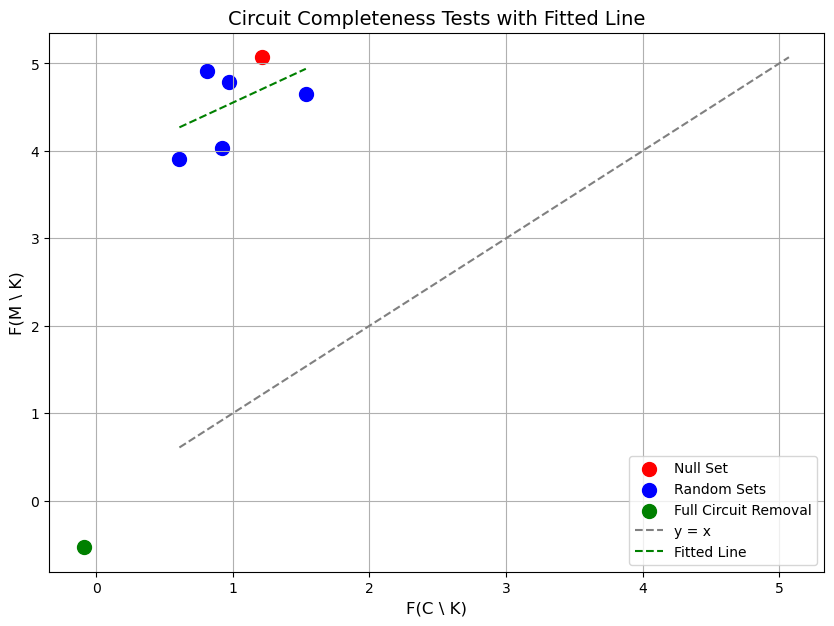

In [99]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
# Extract x and y values
# Separate the data into two groups
# Separate the data into two groups
null_set_xy = xy[0]
random_sets_xy = xy[1:-1]
full_circ_rem = xy[-1]

# Extract x and y values for linear regression
all_x = [point[0] for point in xy[:-1]]
all_y = [point[1] for point in xy[:-1]]

# Fit a linear regression model
regressor = LinearRegression()
all_x_reshaped = np.array(all_x).reshape(-1, 1)  # Reshape for sklearn
regressor.fit(all_x_reshaped, all_y)

# Generate points for the fitted line
fitted_x = np.linspace(min(all_x), max(all_x), 100)
fitted_y = regressor.predict(fitted_x.reshape(-1, 1))

# Extract x and y values for each group
null_set_x, null_set_y = null_set_xy
random_x = [point[0] for point in random_sets_xy]
random_y = [point[1] for point in random_sets_xy]
full_circ_x, full_circ_y = full_circ_rem
# Plot
plt.figure(figsize=(10, 7))

# Null set
plt.scatter(null_set_x, null_set_y, color='red', label='Null Set', s=100)

# Random sets
plt.scatter(random_x, random_y, color='blue', label='Random Sets', s=100)

# Full circuit removal
plt.scatter(full_circ_x, full_circ_y, color='green', label='Full Circuit Removal', s=100)

# Add reference line y = x
x_line = [min([null_set_x] + random_x + [null_set_y] + random_y), max([null_set_x] + random_x + [null_set_y] + random_y)]
plt.plot(x_line, x_line, linestyle="--", color="gray", label="y = x")

# Add fitted regression line
plt.plot(fitted_x, fitted_y, linestyle="--", color="green", label="Fitted Line")

# Customize plot
plt.title("Circuit Completeness Tests with Fitted Line", fontsize=14)
plt.xlabel("F(C \\ K)", fontsize=12)
plt.ylabel("F(M \\ K)", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)

# Show plot
plt.show()

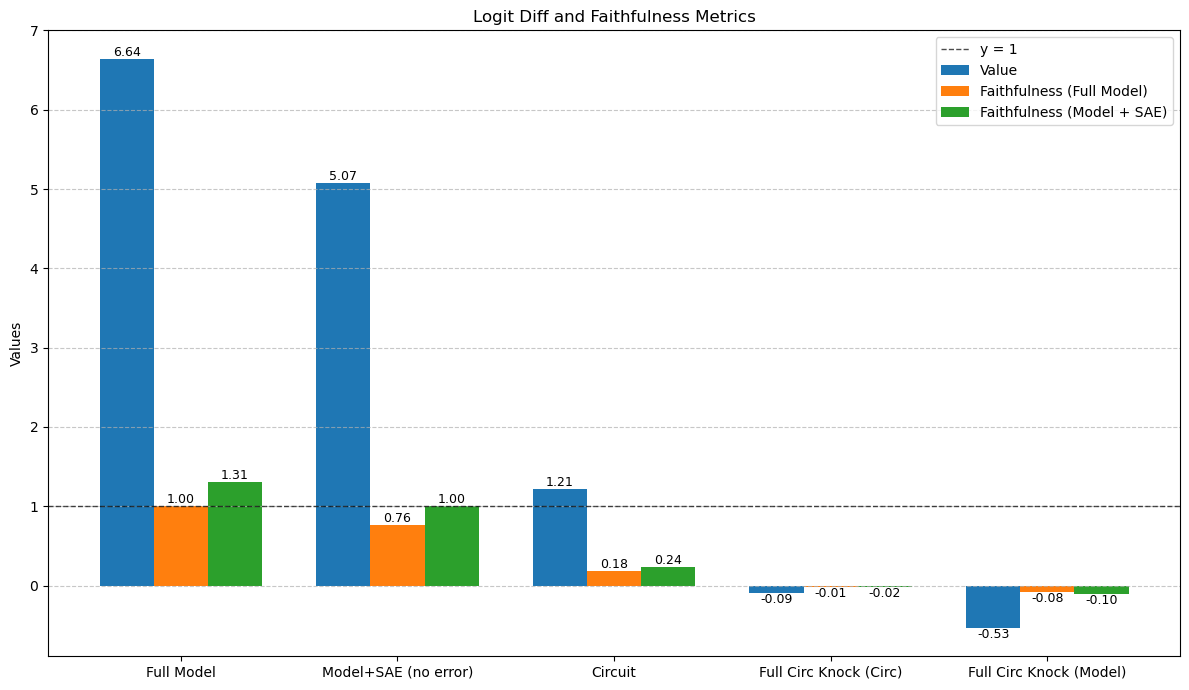

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = [
    "Full Model",
    "Model+SAE (no error)",
    "Circuit",
    "Full Circ Knock (Circ)",
    "Full Circ Knock (Model)"
]
values = [
    full_model_logit_diff, model_logit_diff, circuit_logit_diff, full_circ_knock_circ, full_circ_knock_model
]

# Calculate faithfulness metrics
faithfulness_full_model = [val / values[0] for val in values]
faithfulness_model = [val / values[1] if values[1] != 0 else 0 for val in values]

# Bar positions
x = np.arange(len(labels))
width = 0.25  # Width of each bar

# Plot
plt.figure(figsize=(12, 7))

# Plot bars for the raw values, faithfulness (full model), and faithfulness (model + sae, no error)
bars1 = plt.bar(x - width, values, width, label="Value")
bars2 = plt.bar(x, faithfulness_full_model, width, label="Faithfulness (Full Model)")
bars3 = plt.bar(x + width, faithfulness_model, width, label="Faithfulness (Model + SAE)")

# Add a dotted line at y = 1
plt.axhline(1, color='black', linestyle='--', linewidth=1, alpha=0.7, label="y = 1")

# Add value labels on top of each bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval, 
            f"{yval:.2f}", 
            ha='center', 
            va='bottom' if yval >= 0 else 'top',  # Adjust position for negative bars
            fontsize=9
        )


# Customization
plt.xticks(x, labels, rotation=0) #, ha='right')
plt.ylabel("Values")
plt.title("Logit Diff and Faithfulness Metrics")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


In [100]:
full_model_logit_diff, model_logit_diff, circuit_logit_diff, full_circ_knock_circ, full_circ_knock_model

(6.6416096687316895,
 5.071461900075277,
 1.2142028570175172,
 -0.0869588851928711,
 -0.5319523334503173)

In [86]:
import pickle 
with open("mask_finding/out/mean_mask/circuit_completeness_results.pkl", "wb") as f:
    pickle.dump(random_k_results, f)

In [46]:
model_logit_diff - circuit_logit_diff

2.6782290140787763

In [47]:
2.538733879725138 - 0.8168008724848429

1.7219330072402954

# Completeness Plot 

In [ ]:
full_model_logit_diff = 6.7203
model_sae_logit_diff = 4.8791
circuit_logit_diff = 2.200

In [5]:
og_ld = 7 
sae_ld = 3
circ_ld = 1.5 

In [6]:
1.5/7

0.21428571428571427